# SciFM Summer School - Introduction to Tokenization
The notebook demonstrates training a range of tokenizers using [HuggingFace's tokenizers](https://github.com/huggingface/tokenizers) on the [wikitext](https://github.com/huggingface/tokenizers) dataset. Later, you'll see a few tokenization demonstrations geared toward scientific data (Genomics and Molecules)

In [1]:
# Install Dependencies and Datasets
!pip install tokenizers datasets transformers selfies

In [2]:
from datasets import load_dataset

ds = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Breaking down Tokenization

In [3]:
from tokenizers import Tokenizer

In [4]:
# We're going to walk this bit of text through tokenization, feel free to change it to something fun
sample_text = "2024 SciFM Summer School! 🤖"

First, we'll make the input test "easier" to model by modifying it:
- Lowercase everything
- Remove leading/trailing whitespace
- Replace Unicode charathers with something "equivalent". We don't do this below, but [HF supports several methods](https://huggingface.co/docs/tokenizers/api/normalizers)


In [5]:
from tokenizers import normalizers
norm = normalizers.Sequence([
    normalizers.Strip(),
    normalizers.Lowercase(),
])
sample_normed = norm.normalize_str(sample_text)
sample_normed

'2024 scifm summer school! 🤖'

Next we need to identify the "words" that make up the text and split them into "pre-tokens"
- Are numbers words? `123` -> [`13243`] or [`1`, `3`, `2`]
- Are space important?  [`京都 清水寺の写真`](https://translate.google.com/?sl=auto&tl=en&text=%E4%BA%AC%E9%83%BD%20%E6%B8%85%E6%B0%B4%E5%AF%BA%E3%81%AE%E5%86%99%E7%9C%9F&op=translate) -> [`_京都_`, `_清水寺`, `の写真`]
- What even is a word? `C(Cc1cc(c(OC)c(OC)c1)OC)N` -> [`C`, `(`, `C`, ...]


In [6]:
from tokenizers import pre_tokenizers
pretok = pre_tokenizers.Sequence([
    pre_tokenizers.Punctuation(),
    pre_tokenizers.Whitespace(),
])
sample_pretok = pretok.pre_tokenize_str(sample_normed)
sample_pretok

[('2024', (0, 4)),
 ('scifm', (5, 10)),
 ('summer', (11, 17)),
 ('school', (18, 24)),
 ('!', (24, 25)),
 ('🤖', (26, 27))]

Let's start with the basics: Modeling Language as a sequence of Words (i.e Word-Level tokenization)

We could also do character, but with Unicode (149,878 codepoints) that's not super feasible

In [7]:

from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

tok_wl = Tokenizer(WordLevel(unk_token="[UNK]"))
tok_wl.normalizer = norm
tok_wl.pre_tokenizer = pretok
trainer = WordLevelTrainer(special_tokens=["[UNK]"])  # Don't forget to add the Unknown token!
tok_wl.train_from_iterator(ds["train"]["text"], trainer)

In [8]:
from tokenizers.tools import EncodingVisualizer

""" Helper function for comparing different tokenizers """
def demo_tokenizer(tok, text=sample_text):
    if not isinstance(text, tuple):
        text = (text, )

    if not isinstance(tok, Tokenizer):
      tok = tok.backend_tokenizer

    out = tok.encode(*text)
    ids = out.ids
    tokens = out.tokens
    token_type = None
    sz = tok.get_vocab_size()

    print(f"Input: `{text}`")
    print(f"Tokens: {tokens}")
    print(f"Tokens IDs: {ids}")
    token_type and print(f"Tokens Type: {token_type}")
    print(f"Vocab Size: {sz}")

    if len(text) == 1:
      vis = EncodingVisualizer(tok)
      vis(*text)


In [9]:
demo_tokenizer(tok_wl)

Input: `('2024 SciFM Summer School! 🤖',)`
Tokens: ['[UNK]', '[UNK]', 'summer', 'school', '!', '[UNK]']
Tokens IDs: [0, 0, 698, 260, 388, 0]
Vocab Size: 30000


In [10]:
# Some models need extra tokens to deliminate different parts of the input
from tokenizers import processors
from copy import deepcopy

tok_wl_post = deepcopy(tok_wl)
tok_wl_post.add_special_tokens(["[SEP]", "[CLS]"])
tok_wl_post.post_processor = processors.BertProcessing(
    sep=("[SEP]", tok_wl_post.token_to_id("[SEP]")),
    cls=("[CLS]", tok_wl_post.token_to_id("[CLS]")),
)
print(f"Tokenize a single sentence: {tok_wl_post.encode(sample_text).tokens}")
print(f"A Pair of sentences: {tok_wl_post.encode('Why did the Foundation Model visit the University of Michigan?', sample_text).tokens}")

Tokenize a single sentence: ['[CLS]', '[UNK]', '[UNK]', 'summer', 'school', '!', '[UNK]', '[SEP]']
A Pair of sentences: ['[CLS]', 'why', 'did', 'the', 'foundation', 'model', 'visit', 'the', 'university', 'of', 'michigan', '?', '[SEP]', '[UNK]', '[UNK]', 'summer', 'school', '!', '[UNK]', '[SEP]']


# Splitting Words into Subwords

## Byte-Pair Encoding
BPE has it's roots as a data compression algorithum and is used in a few well-known models (i.e. GPT-2). We're going to do a deeper dive into this in a bit, but at a high-level:

1. Split the corpus into words
2. Init the vocab with the alphabet (Roughly)
3. Count the frequency of co-occuring bytes
3. Merge the most freqent pairs into a meta-token
4. Repeat until the vocab hits the target size or there are no more merges to make

In [11]:
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

tok_bpe = Tokenizer(BPE(unk_token="[UNK]"))
tok_bpe.normalizer = norm
tok_bpe.pre_tokenizer = pretok
trainer = BpeTrainer(
    vocab_size=tok_wl.get_vocab_size(), # Not a great choice, but helpful for comparison
    special_tokens=["[UNK]"],
    show_progress=True
)
tok_bpe.train_from_iterator(
    ds["train"]["text"],
    trainer,
    length=len(ds["train"])
)

In [12]:
demo_tokenizer(tok_bpe)

Input: `('2024 SciFM Summer School! 🤖',)`
Tokens: ['20', '24', 'sc', 'if', 'm', 'summer', 'school', '!', '[UNK]']
Tokens IDs: [1127, 2045, 1154, 1042, 51, 2917, 1724, 1, 0]
Vocab Size: 30000


## WordPiece
As Google never open-sourced WordPiece the exact algorithm is unknown. HuggingFace's WordPiece trainer is actually just a [wrapper around their BPE trainer](https://github.com/huggingface/tokenizers/blob/fdd26ba9a3f0c133427aab0423888cbde91362d7/tokenizers/src/models/wordpiece/trainer.rs#L165C4-L177C6) with an added flag to add a subword prefix.

There are few other differences from BPE, _as implimented by HuggingFace_, including:
- Instead of tokenizing and then applying merges, WordPiece uses the largest matching token
- If WordPiece can't tokenize part of a word it marks _the whole word_ as unknown

In [13]:
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer

tok_wp = Tokenizer(WordPiece(unk_token="[UNK]"))
tok_wp.normalizer = norm
tok_wp.pre_tokenizer = pretok
trainer = WordPieceTrainer(
    vocab_size=tok_wl.get_vocab_size(), # Not a great choice, but helpful for comparison
    special_tokens=["[UNK]"],
    show_progress=True,
)
tok_wp.train_from_iterator(
    ds["train"]["text"],
    trainer,
    length=len(ds["train"])
)

In [14]:
demo_tokenizer(tok_wp)

Input: `('2024 SciFM Summer School! 🤖',)`
Tokens: ['202', '##4', 'sci', '##f', '##m', 'summer', 'school', '!', '[UNK]']
Tokens IDs: [13237, 968, 26526, 941, 951, 3779, 2443, 1, 0]
Vocab Size: 30000


## Unigram
Unlike BPE/WordPiece which build their vocabulary from an intial (small) alphabet, Unigram starts with a large vocabulary and then iteratively removes tokens that don't contribute much.

1. Compute the most probable tokenization of the corpus
2. Repeat but using a vocabulary that holds out a token, record the log-likelihood of the resulting model
3. Removed the bottom X% of tokens (the ones with the smallest change in the log-likelihood when removed)
4. Repeat till the vocab reaches the target size

Conceptually at infrence time (HF doesn't impliment this), multiple tokenization can then be computed and then sampled from based on their proability.

In [15]:
from tokenizers.models import Unigram
from tokenizers.trainers import UnigramTrainer

tok_uni = Tokenizer(Unigram())
tok_uni.normalizer = norm
tok_uni.pre_tokenizer = pretok
trainer = UnigramTrainer(
    vocab_size=tok_wl.get_vocab_size() // 2, # Not a great choice, but helpful for comparison
    unk_token="[UNK]",
    shrinking_factor=0.1,
    show_progress=True,
)
tok_uni.train_from_iterator(
    ds["train"]["text"],
    trainer,
    length=len(ds["train"])
)

In [16]:
demo_tokenizer(tok_uni)

Input: `('2024 SciFM Summer School! 🤖',)`
Tokens: ['20', '24', 's', 'c', 'i', 'f', 'm', 'summer', 'school', '!', '🤖']
Tokens IDs: [182, 526, 1, 48, 25, 46, 44, 800, 265, 540, 0]
Vocab Size: 15000


# Pre-Trained Tokenizers
Don't want to train your own tokenizer? Try out a pre-trained one

In [17]:
from transformers import AutoTokenizer
import selfies

In [18]:
tok_gpt = AutoTokenizer.from_pretrained("openai-community/gpt2")
demo_tokenizer(tok_gpt)

Input: `('2024 SciFM Summer School! 🤖',)`
Tokens: ['20', '24', 'ĠSci', 'FM', 'ĠSummer', 'ĠSchool', '!', 'ĠðŁ', '¤', 'ĸ']
Tokens IDs: [1238, 1731, 10286, 23264, 10216, 3961, 0, 12520, 97, 244]
Vocab Size: 50257


In [19]:
tok_galactica = AutoTokenizer.from_pretrained("facebook/galactica-125m")
demo_tokenizer(tok_galactica)

Input: `('2024 SciFM Summer School! 🤖',)`
Tokens: ['2', '0', '2', '4', 'ĠSci', 'FM', 'ĠSummer', 'ĠSchool', '!', 'Ġ', 'ð', 'Ł', '¤', 'ĸ']
Tokens IDs: [40, 38, 40, 42, 18844, 13788, 18074, 6678, 23, 243, 195, 276, 120, 267]
Vocab Size: 50000


In [20]:
# Some Tokenizers are designed for pairs of sentences (Think RAG)
tok_qa = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
demo_tokenizer(tok_qa, ("How can I learn more about Scientific Foundation Models?", "Attend SciFM Summer School!"))

Input: `('How can I learn more about Scientific Foundation Models?', 'Attend SciFM Summer School!')`
Tokens: ['[CLS]', 'how', 'can', 'i', 'learn', 'more', 'about', 'scientific', 'foundation', 'models', '?', '[SEP]', 'attend', 'sci', '##fm', 'summer', 'school', '!', '[SEP]']
Tokens IDs: [101, 2129, 2064, 1045, 4553, 2062, 2055, 4045, 3192, 4275, 1029, 102, 5463, 16596, 16715, 2621, 2082, 999, 102]
Vocab Size: 30522


In [21]:
# FYI: Do check the remote code before running it on your own system.
tok_molformer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)
demo_tokenizer(tok_molformer, "C1=CC2=C(C=C1O)C(=CN2)CCN")

Input: `('C1=CC2=C(C=C1O)C(=CN2)CCN',)`
Tokens: ['<bos>', 'C', '1', '=', 'C', 'C', '2', '=', 'C', '(', 'C', '=', 'C', '1', 'O', ')', 'C', '(', '=', 'C', 'N', '2', ')', 'C', 'C', 'N', '<eos>']
Tokens IDs: [0, 4, 8, 12, 4, 4, 11, 12, 4, 6, 4, 12, 4, 8, 9, 7, 4, 6, 12, 4, 10, 11, 7, 4, 4, 10, 1]
Vocab Size: 2362


In [22]:
tok_selformer = AutoTokenizer.from_pretrained("HUBioDataLab/SELFormer")
demo_tokenizer(tok_selformer, selfies.encoder("C1=CC2=C(C=C1O)C(=CN2)CCN"))

Input: `('[C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][O][C][=Branch1][Branch1][=C][N][Ring1][Branch2][C][C][N]',)`
Tokens: ['<s>', 'C', '=', 'C', 'C', '=', 'C', 'Branch', '1', '=', 'Branch', '1', 'C', '=', 'C', 'Ring', '1', '=', 'Branch', '1', 'O', 'C', '=', 'Branch', '1', 'Branch', '1', '=', 'C', 'N', 'Ring', '1', 'Branch', '2', 'C', 'C', 'N', '</s>']
Tokens IDs: [1, 25, 21, 25, 25, 21, 25, 55, 12, 21, 55, 12, 25, 21, 25, 60, 12, 21, 55, 12, 33, 25, 21, 55, 12, 55, 12, 21, 25, 32, 60, 12, 55, 13, 25, 25, 32, 2]
Vocab Size: 428


# Comparing Tokenizers

In [23]:
trained = {
    "WordLevel": tok_wl,
    "BPE": tok_bpe,
    "WordPiece": tok_wp,
    "Unigram": tok_uni,
    "GPT-2": tok_gpt,
    "Galactica": tok_galactica,
    "BERT": tok_qa,
    # Using a tokenizer for molecules on articles from wikipedia doesn't really make sense.
    # But this is Summer School! So take chances, make mistakes, and get messy!
    # "MoLFormer": tok_molformer,
    # "SELFormer": tok_selformer,   # ditto
}

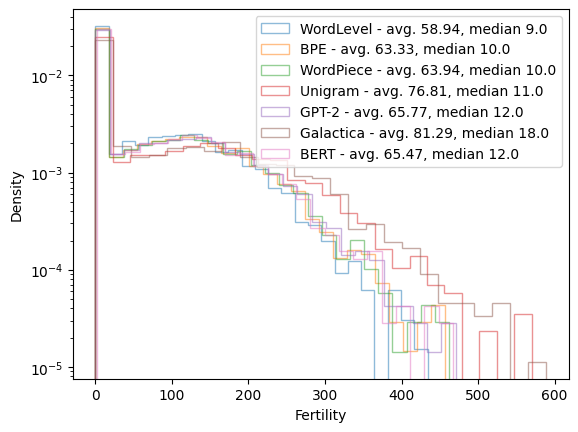

In [24]:
import matplotlib.pyplot as plt
from numpy import mean, median

def encode(tok, x):
  if isinstance(tok, Tokenizer):
    return tok.encode(x["text"]).ids
  else:
    return tok(x["text"])["input_ids"]

for name, tok in trained.items():
    fertility = [len(encode(tok, x)) for x in ds["validation"]]
    label = f"{name} - avg. {mean(fertility):.2f}, median {median(fertility):.1f}"
    plt.hist(fertility, bins="scott", alpha=0.5, label=label, density=True, log=True, histtype='step')

plt.xlabel('Fertility')
plt.ylabel('Density')
plt.legend()
plt.show()

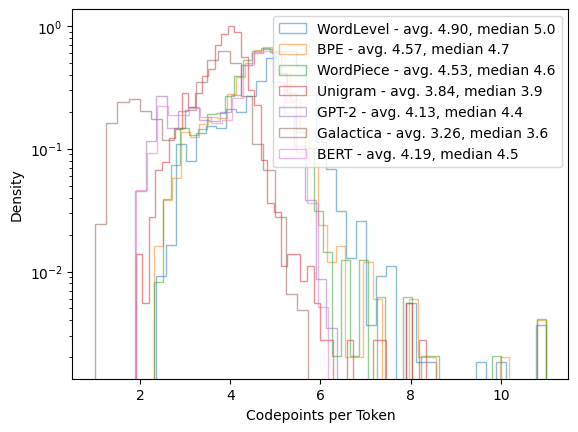

In [25]:
for name, tok in trained.items():
    fertility = [len(x["text"]) / len(encode(tok, x)) for x in ds["validation"] if len(x["text"]) > 0]
    label = f"{name} - avg. {mean(fertility):.2f}, median {median(fertility):.1f}"
    plt.hist(fertility, bins="scott", alpha=0.5, label=label, density=True, log=True, histtype='step')

plt.xlabel('Codepoints per Token')
plt.ylabel('Density')
plt.legend()
plt.show()

In [26]:
num_unknown = dict()
for name, tok in trained.items():
    if isinstance(tok, Tokenizer):
        unk_token_id = tok.get_vocab()["[UNK]"]
    else:
        unk_token_id = tok.unk_token_id or None

    num_unknown[name] = sum([ unk_token_id in encode(tok, x) for x in ds["validation"]]) / len(ds["validation"])

num_unknown

{'WordLevel': 0.45851063829787236,
 'BPE': 0.007978723404255319,
 'WordPiece': 0.007978723404255319,
 'Unigram': 0.007978723404255319,
 'GPT-2': 0.0,
 'Galactica': 0.0,
 'BERT': 0.006117021276595745}

# What's Next?
Check out these resources:

- [HuggingFace's Documentation](https://huggingface.co/docs/tokenizers/index)
- [HuggingFace's Tokenization NLP Course](https://huggingface.co/learn/nlp-course/chapter6/1)
- [Google's SentencePiece Library](https://github.com/google/sentencepiece)

Some papers:
- [Japanese and Korean voice search](https://doi.org/10.1109/ICASSP.2012.6289079): The WordPiece Paper
- [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates](https://doi.org/10.18653/v1/P18-1007): The Unigram Paper
- [A new algorithm for data compression](https://www.semanticscholar.org/paper/A-new-algorithm-for-data-compression-Gage/1aa9c0045f1fe8c79cce03c7c14ef4b4643a21f8) - Created BPE as a compression algorithm
- [Neural Machine Translation of Rare Words with Subword Units](http://arxiv.org/abs/1508.07909) - Proposed using BPE for Neural Machine Translation
- [“Found in Translation”: predicting outcomes of complex organic chemistry reactions using neural sequence-to-sequence models](https://doi.org/10.1039/C8SC02339E): Proposed Regular Expression for Splitting Molecules (Thanks [Philippe Schwaller](https://scholar.google.com/citations?user=Tz0I4ywAAAAJ)!)
- [Between words and characters: A Brief History of Open-Vocabulary Modeling and Tokenization in NLP](http://arxiv.org/abs/2112.10508)
- [Exploring bert’s vocabulary](http://juditacs.github.io/2019/02/19/bert-tokenization-stats.html) a blog post by [Judit Ács](https://scholar.google.hu/citations?user=rIStlyMAAAAJ&hl=en) that introduced fertility as a metric. Later used by [Workshop et al. 2023](http://arxiv.org/abs/2211.05100), [Rust et al. 2021](https://doi.org/10.18653/v1/2021.acl-long.243), [Ali et al. 2024](http://arxiv.org/abs/2310.08754) and now you!